### 0.导入函数库

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy import read
from obspy.core import read
from obspy import read_events
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.cross_correlation import correlate
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

### 1.波形旋转

1 Event(s) in Catalog:
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1  MW
1 Trace(s) in Stream:
BW.RLAS..BJZ | 2011-03-11T05:46:23.200899Z - 2011-03-11T06:46:23.150899Z | 20.0 Hz, 72000 samples
3 Trace(s) in Stream:
GR.WET..BHE | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples
GR.WET..BHN | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples
GR.WET..BHZ | 2011-03-11T05:46:23.225000Z - 2011-03-11T06:46:23.175000Z | 20.0 Hz, 72000 samples


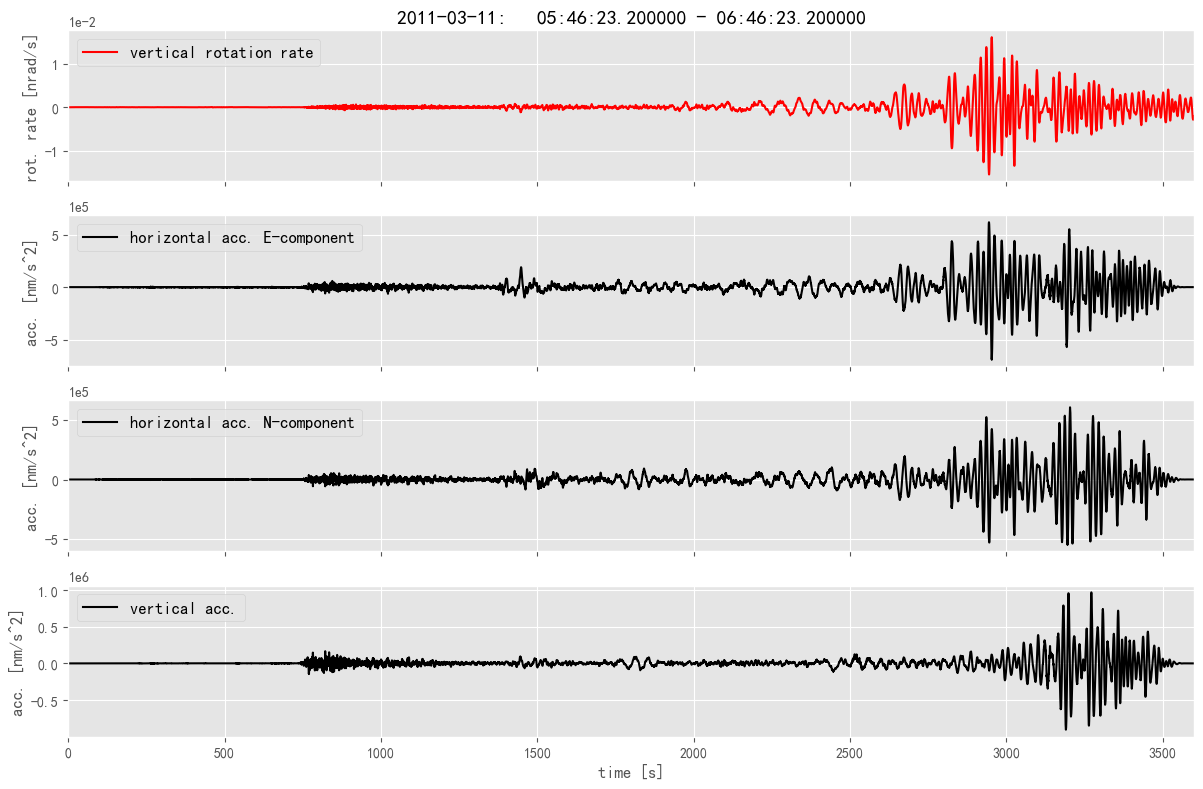

In [14]:
cat = read_events("../data/iris_catalog.xml")
event = cat[0]
print(cat)
start = event.origins[0].time
end = start + 3600

AC = read("../data/event_bfg.mseed")
print(RLAS)
print(AC)

RLAS.detrend(type='linear')
RLAS[0].data = RLAS[0].data * 1/6.3191 * 1e-3

AC.detrend(type='linear')
AC.taper(max_percentage=0.05)

paz_sts2 = {'poles': [(-0.0367429 + 0.036754j), (-0.0367429 - 0.036754j)],
            'sensitivity': 0.944019640,
            'zeros': [0j],
            'gain': 1.0}

AC.simulate(paz_remove=paz_sts2, remove_sensitivity=True)

startaim = max([tr.stats.starttime for tr in (AC + RLAS)])
endtaim = min([tr.stats.endtime for tr in (AC + RLAS)])

AC.trim(startaim, endtaim, nearest_sample=True)
RLAS.trim(startaim, endtaim, nearest_sample=True)

# 绘图
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True)
ax1.set_title(str(start.date) + ':   ' + str(start.time) + " - " + str(end.time))
ax1.plot(RLAS[0].times(), RLAS[0],'r',label='vertical rotation rate')
ax1.set_ylabel('rot. rate [nrad/s]')
ax2.plot(AC[0].times(),AC[0],'k',label='horizontal acc. E-component')
ax2.set_ylabel('acc. [nm/s^2]')
ax3.plot(AC[1].times(),AC[1],'k',label='horizontal acc. N-component')
ax3.set_ylabel('acc. [nm/s^2]')
ax4.plot(AC[2].times(),AC[2],'k',label='vertical acc.')
ax4.set_ylabel('acc. [nm/s^2]')
ax4.set_xlabel('time [s]')

for ax in [ax1,ax2,ax3,ax4]:
    ax.legend(loc=2, prop={"size":12})
    ax.yaxis.major.formatter.set_powerlimits((-1,2))
    ax.set_xlim(0,max(AC[0].times()))

fig.tight_layout()
plt.show()

Epicentral distance [m]:  9127350.828896653
Theoretical azimuth [deg]:  329.4079811585143
Theoretical backazimuth [deg]:  37.602787067079454


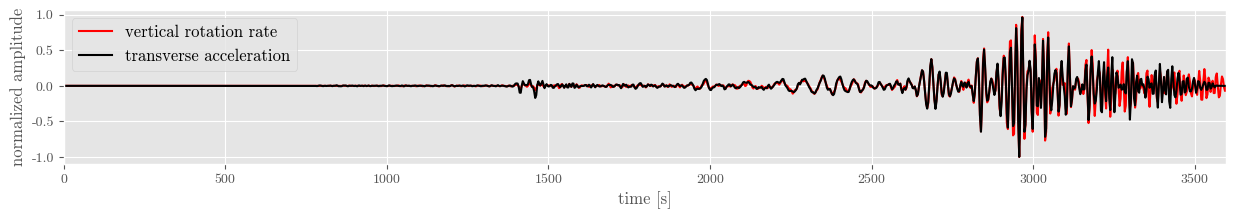

In [20]:
RLAS.decimate(factor=4)
AC.decimate(factor=4)
high_cut = 1.0
low_cut = 0.005

RLAS.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)
AC.filter('bandpass', freqmax=high_cut, freqmin=low_cut, corners=2, zerophase=True)

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [m]: ', baz[0])
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

# rotate
AC.rotate(method='NE->RT',back_azimuth=baz[2])
plt.figure(figsize=(15,2))

ax = plt.subplot(111)
ax.plot(RLAS[0].times(), RLAS[0].data/np.max(np.abs(RLAS[0].data)), 'r', label='vertical rotation rate')
ax.plot(AC[0].times(), AC[0].data/np.max(np.abs(AC[0].data)), 'k', label='transverse acceleration')
ax.legend(loc=2, prop={"size":12})
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(0,max(RLAS[0].times()))

plt.show()

### 2.小波分析

In [ ]:
st = obspy.read("../data/detrend_test_stream.mseed")
tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 1
f_max = 50

scalogram = cwt(tr.data, dt, 8, f_min, f_max)

fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()

### 3.波形相关分析

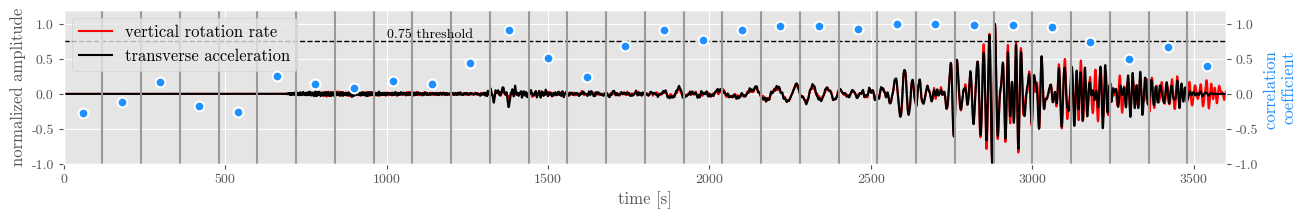

In [9]:
AC = read('../data/acc_Tohoku_preproc.mseed')
RLAS = read('../data/rot_Tohoku_preproc.mseed')
cat = read_events('../data/xml_Tohoku.xml')
event = cat[0]

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

sampling_rate = int(RLAS[0].stats.sampling_rate)
sec = 120  # window length for correlation (teleseismic event)

# calculate correlation coefficients
corrcoefs = []
for ic in range(0, len(RLAS[0]) // (int(sampling_rate * sec))):
        coeffs = correlate(RLAS[0].data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)],
                       AC[0].data[sampling_rate * sec * ic : sampling_rate * sec * (ic + 1)], 0)
        corrcoefs.append(coeffs[0])

# plot waveforms in comparison and correlation coefficients in time windows
plt.figure(figsize=(15,2))
ax=plt.subplot(111)
ax.plot(RLAS[0].times(), RLAS[0].data/np.max(np.abs(RLAS[0].data)), 'r', label='vertical rotation rate')
ax.plot(AC[0].times(), AC[0].data/np.max(np.abs(AC[0].data)), 'k', label='transverse acceleration')
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_ylim(-1.0,1.2)
ax.axhline(y=.75, linewidth=1, c='k',ls='dashed')
ax.legend(loc=2, prop={"size":12})
for xi in range(sec,sec * len(corrcoefs)-1, sec):
    ax.axvline(x=xi, color='.6')

ax2=ax.twinx()
ax2.scatter(np.arange(60,sec * len(corrcoefs),sec),corrcoefs,c='Dodgerblue',s=50,edgecolors='w',linewidth=1.5)
ax2.set_xlim(0, RLAS[0].times()[-1])
ax2.set_ylim(-1,1.2)
ax2.set_ylabel('correlation \ncoefficient', color='Dodgerblue')
ax2.annotate('0.75 threshold', xy=(1000,.8),xycoords='data')
ax2.grid(visible=False)

plt.show()

### 4.频散分析

P-wave arrival:  743.918847002784 sec
S-wave arrival:  1362.2375915312396 sec


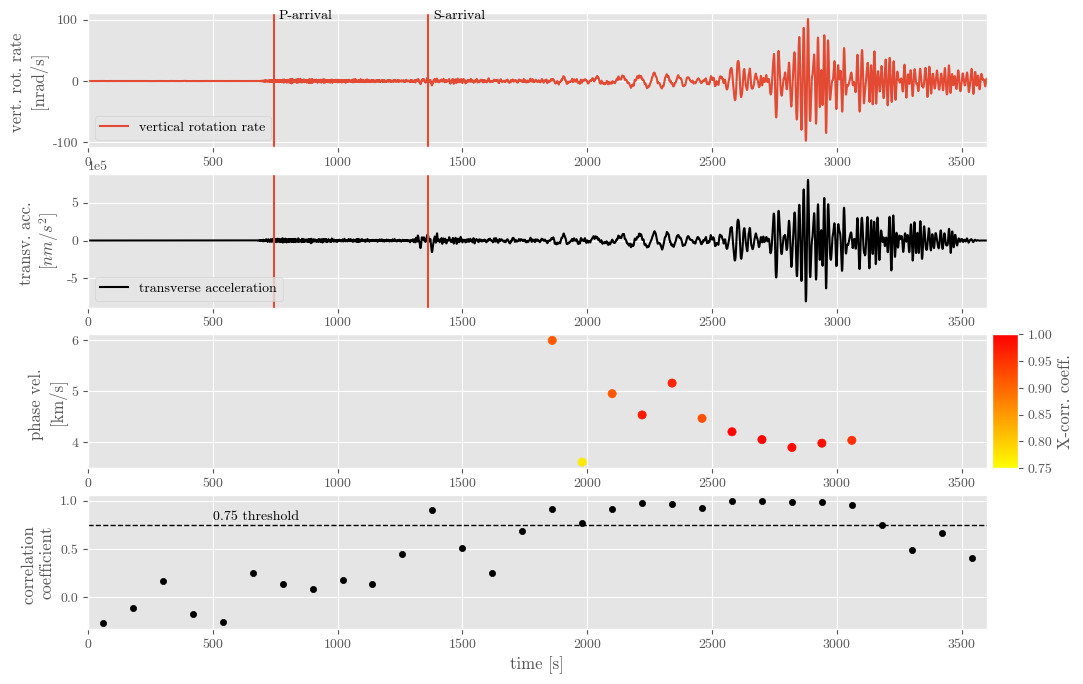

In [13]:
TauPy_model = TauPyModel('ak135')
arrivals_p = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["P","p","Pdiff","PP","PKiKP","PKIKP","Pn","Pg"])
arrivals_s = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["S","s","Sdiff","SS","SKiKS","SKIKS","Sn","Sg"])
tiemp = []
tiems = []
for i in range(0,len(arrivals_p)): tiemp.append(arrivals_p[i].time)
for ii in range(0,len(arrivals_s)): tiems.append(arrivals_s[ii].time)

# first arrivals
arriv_p = min(tiemp)
arriv_s = min(tiems)
print("P-wave arrival: ", arriv_p, "sec")
print("S-wave arrival: ", arriv_s, "sec")

sampling_rate = int(RLAS[0].stats.sampling_rate)

# calculate Love wave phase velocities [km/s] for time windows featuring correlation coefficients > 0.75
# and after S-wave arrival
surf = int(arriv_s/120.)+2  # window number after S-waves
phasv = []
for iph in range(surf, len(corrcoefs)):
    if corrcoefs[iph] >= 0.75:
        phas_v = 0.001 * 0.5 * max(AC[0].data[sampling_rate * sec * iph : sampling_rate * sec * (iph + 1)]) /\
                 max(RLAS[0].data[sampling_rate * sec * iph : sampling_rate * sec * (iph + 1)])
    else:
        phas_v = np.NaN
    phasv.append(phas_v)

# 绘图
plt.subplot2grid((4, 30), (0, 0), colspan=29)
plt.plot(RLAS[0].times(), RLAS[0].data,label='vertical rotation rate')
plt.xlim(0, RLAS[0].times()[-1])
plt.ylabel('vert. rot. rate \n[nrad/s]')
plt.legend(loc=3)

# add P- and S-wave arrivals
plt.axvline(arriv_p);plt.annotate('P-arrival', xy=(arriv_p+20,np.max(RLAS[0].data)),xycoords='data');
plt.axvline(arriv_s);plt.annotate('S-arrival', xy=(arriv_s+20,np.max(RLAS[0].data)),xycoords='data');

# transverse acceleration
plt.subplot2grid((4, 30), (1, 0), colspan=29)
plt.plot(AC[0].times(), AC[0].data, 'k',label='transverse acceleration')
plt.xlim(0, AC[0].times()[-1])
plt.ylabel('transv. acc. \n[$nm/s^2$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.legend(loc=3)
plt.axvline(arriv_p)
plt.axvline(arriv_s)

# phase velocities plot
plt.subplot2grid((4, 30), (2, 0), colspan=29)
vel = plt.scatter(np.arange(sec/2. + surf*sec, sec/2. + sec * (len(phasv)+surf), sec), phasv,c=corrcoefs[surf:], vmin=0.75, vmax=1, s=35,cmap=plt.cm.autumn_r)
plt.xlim(0, RLAS[0].stats.delta * len(RLAS[0].data))
plt.ylabel('phase vel. \n[km/s]')
plt.xlabel('time [s]')

# add colorbar
fig = plt.subplot2grid((4, 30), (2, 29))
norm = mpl.colors.Normalize(vmin=.75, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.autumn_r, norm=norm, orientation='vertical')
cb1.set_ticks([0.75,0.8,0.85,0.9,0.95,1])
cb1.set_label(u'X-corr. coeff.', fontweight='bold')

# correlation coefficients plot
plt.subplot2grid((4, 30), (3, 0), colspan=29)
plt.scatter(np.arange(sec/2., sec/2. + sec * len(corrcoefs), sec), corrcoefs,c='k', s=20)
plt.xlim(0, RLAS[0].stats.delta * len(RLAS[0].data))
plt.xlabel('time [s]')
plt.ylabel('correlation \ncoefficient')
plt.axhline(y=.75, linewidth=1, c='k',ls='dashed')
plt.annotate('0.75 threshold', xy=(500,.8),xycoords='data')

plt.show()